In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

20.0

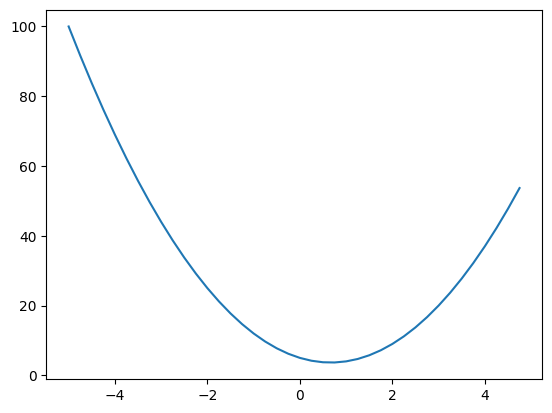

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [ ]:
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [ ]:
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

In [ ]:
h = 0.0000000001
x = 2/3
(f(x + h) - f(x)) / h

0.0

In [ ]:
a = 2.0
b = -3
c = 10.0
d = a*b+c
print(d)

4.0


In [ ]:
h = 0.00001

a = 2.0
b = -3
c = 10.0

d1 = a*b+c
c += h
d2 = a*b+c

print(d1)
print(d2)
print((d2-d1)/h)

4.0
4.00001
0.9999999999621422


In [ ]:
class Value:
  def __init__(self, data, _children = (),_op = '',label = ''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __rmul__(self,other):
    return self * other

  def __radd__(self,other):
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x),(self,),'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def __truediv__(self,other):
    return self * other ** -1

  def __pow__(self,other):
    assert isinstance(other,(int,float)), "other float or int power allowed"
    out = Value(self.data ** other,(self,),f'**{other}')

    def _backward():
      self.grad += other * self.data ** (other - 1) * out.grad
    out._backward =  _backward

    return out

  def __neg__(self):
    return self * -1

  def __sub__(self,other):
    return self + (-other)

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
a = Value(2.0)
b = Value(4.0)
a ** 2

Value(data=4.0)

In [ ]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10,label = 'c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2,label = 'f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

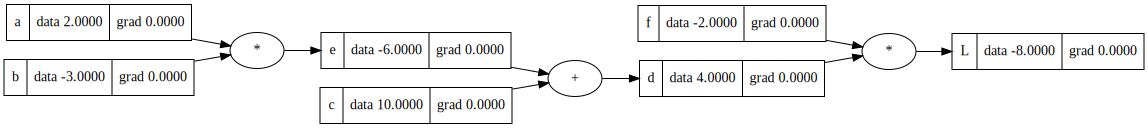

In [ ]:

draw_dot(L)

In [ ]:
a.grad = 6
b.grad = -4
c.grad = -2
d.grad = -2
e.grad = -2
f.grad = 4
L.grad = 1

In [ ]:
def lol():
  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  # b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

lol()

0.0


In [ ]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


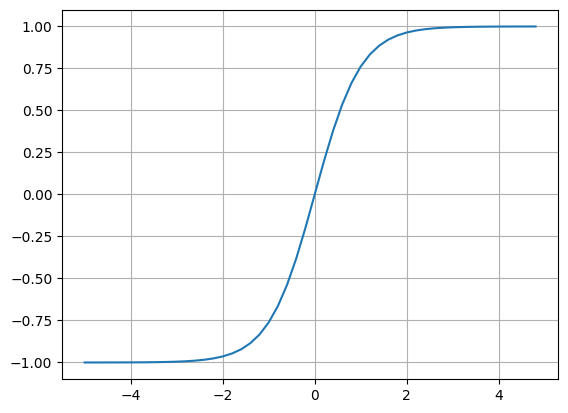

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

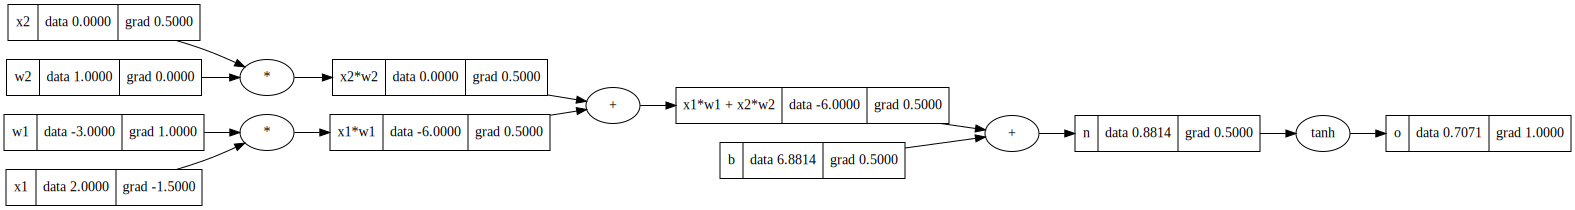

In [ ]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

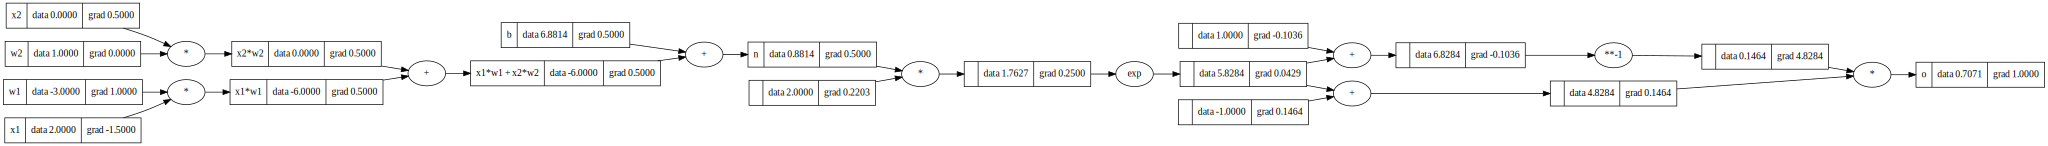

In [ ]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2 * n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'

o.backward()
draw_dot(o)

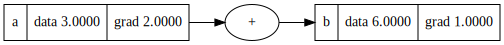

In [ ]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

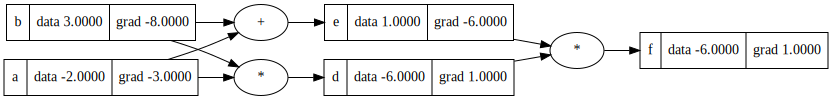

In [ ]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [ ]:
o.backward()

In [ ]:
# topo = []
# visited = set()
# def build_topo(v):
#   if v not in visited:
#     visited.add(v)
#     for child in v._prev:
#       build_topo(child)
#     topo.append(v)
# build_topo(o)
# topo

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=-1),
 Value(data=6.881373587019543),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=2),
 Value(data=1.7627471740390863),
 Value(data=5.828427124746192),
 Value(data=4.828427124746192),
 Value(data=1),
 Value(data=6.828427124746192),
 Value(data=0.1464466094067262),
 Value(data=0.7071067811865477)]

In [ ]:
o.grad = 1.0
for node in reversed(topo):
  node._backward()

In [ ]:
x2w2._backward()
x1w1._backward()

In [ ]:
x1w1x2w2._backward()

In [ ]:
b._backward()

In [ ]:
o.grad = 1.0
o._backward()

In [ ]:
n._backward()

In [ ]:
o.grad = 1.0
n.grad = 1 - o.data**2
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [ ]:
1 - o.data**2

0.4999999999999998

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
import random

In [ ]:
class Neuron:
  def __init__(self,nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self,x):
    act = sum((wi * xi for wi,xi in zip(self.w,x)),self.b)
    out = act.tanh()
    return out

  def parameteres(self):
    return self.w + [self.b]

class Layer:

  def __init__(self,nin,nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameteres()]

class MLP:
  def __init__(self,nin,nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.42523254260120563)

In [ ]:
len(n.parameters())

41

In [ ]:
# draw_dot(n(x))

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [ ]:
for k in range(20):

  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt) ** 2 for yout, ygt in zip(ypred,ys))

  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k,loss.data)

0 0.000480097421055563
1 0.00047891607630887363
2 0.0004777404237259501
3 0.00047657042257546914
4 0.00047540603251218136
5 0.0004742472135723273
6 0.00047309392616918833
7 0.0004719461310886187
8 0.0004708037894847445
9 0.00046966686287559605
10 0.00046853531313890756
11 0.0004674091025079402
12 0.0004662881935673308
13 0.0004651725492490435
14 0.0004640621328283658
15 0.000462956907919932
16 0.00046185683847383926
17 0.0004607618887718008
18 0.0004596720234233383
19 0.0004585872073620641


In [ ]:
ypred

[Value(data=0.9948693145086023),
 Value(data=-0.988100671641155),
 Value(data=-0.9881104391567554),
 Value(data=0.9877808510397165)]

#### Trial 2

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

20.0

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

In [ ]:
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [ ]:
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

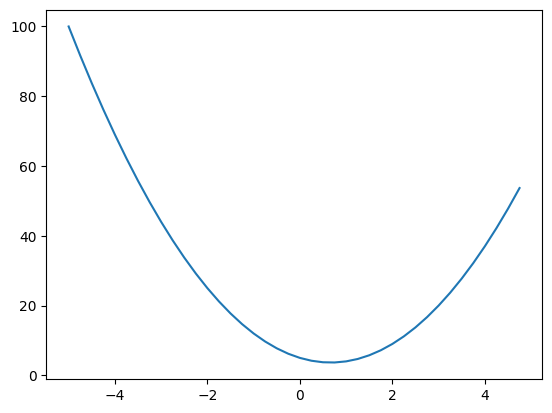

In [ ]:
plt.plot(xs, ys)

In [ ]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [ ]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [ ]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)

print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [63]:
class Value:
  def __init__(self,data, _children = (), _op = '', label = ''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self,other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data,(self,other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

  def __mul__(self,other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data,(self,other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self,other):
    return self * other

  def __radd__(self,other):
    return self + other

  def __neg__(self):
    return self * -1

  def exp(self):
    x = self.data
    out = Value(math.exp(x),(self,),'exp')
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def __truediv__(self,other):
    return self * other ** -1

  def __pow__(self,other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data ** other,(self,),f'**{other}')
    def _backward():
      self.grad += other * self.data ** (other - 1) * out.grad
    out._backward = _backward
    return out

  def __sub__(self,other):
    return self + (-other)

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t,(self,),'tanh')
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

In [64]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [ ]:
L.grad = 1
d.grad = -2
f.grad = 4
c.grad = -2
e.grad = -2
a.grad = 6.0
b.grad = -4.0

In [ ]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e + c
L = d * f
L

Value(data=-7.286496)

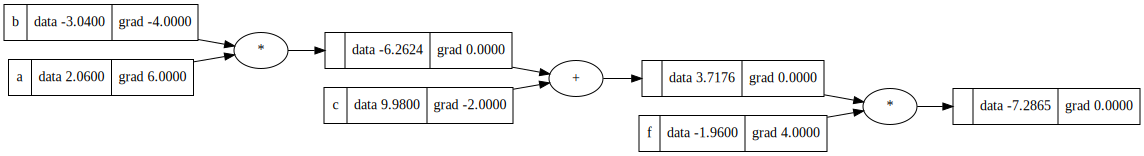

In [ ]:
draw_dot(L)

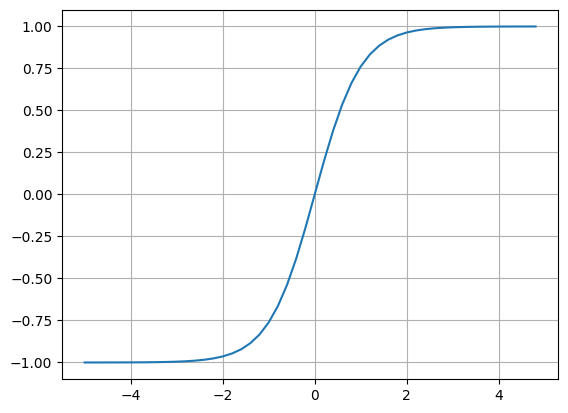

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [65]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [ ]:
# o.grad = 1.0
# n.grad = 1 - o.data**2
# x1w1x2w2.grad = 0.5
# b.grad = 0.5
# x1w1.grad = 0.5
# x2w2.grad = 0.5
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad

# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

In [ ]:
o.grad = 1.0
o._backward()

In [ ]:
n._backward()

In [ ]:
b._backward()

In [ ]:
x1w1x2w2._backward()

In [ ]:
x2w2._backward()
x1w1._backward()

In [66]:
o.backward()

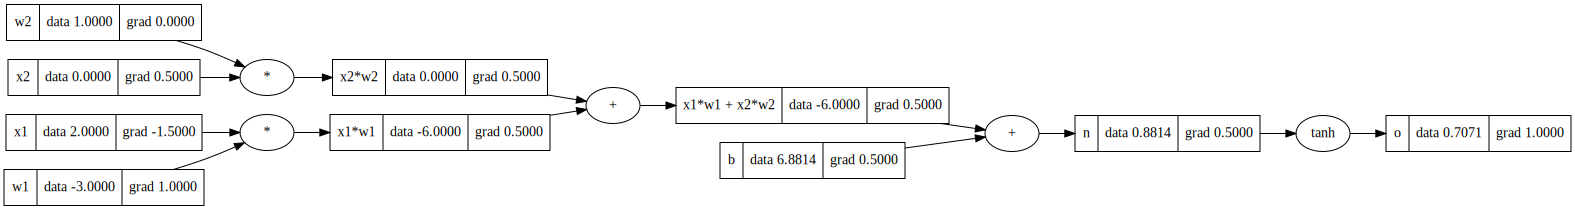

In [67]:
draw_dot(o)

In [ ]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [ ]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

for node in reversed(topo):
  node._backward()

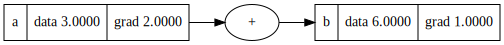

In [ ]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [68]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'

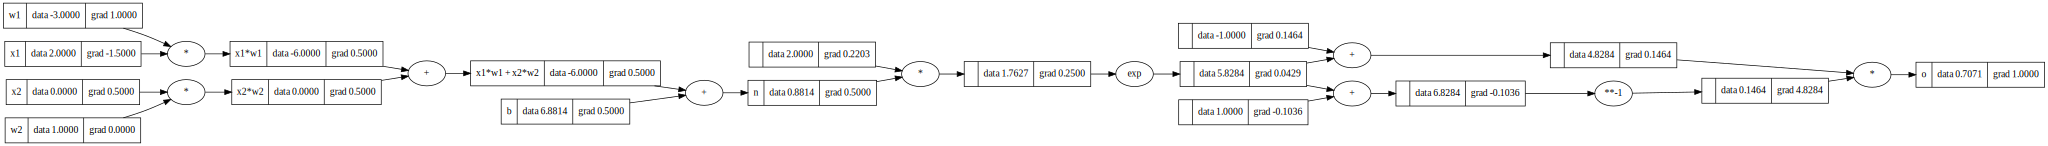

In [70]:
o.backward()
draw_dot(o)

In [73]:
import random

In [136]:
class Neuron:
  def __init__(self,nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self,x):
    act = sum((wi * xi for wi,xi in zip(self.w,x)),self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

In [137]:
class Layer:
  def __init__(self,nin,nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

In [138]:
class MLP:
  def __init__(self,nin,nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [139]:
x = [2,3]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.975616382782114)

In [141]:
len(n.parameters())

41

In [106]:
# draw_dot(n(x))

In [218]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [143]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.969470461727521),
 Value(data=-0.9447835409023236),
 Value(data=-0.7966507802227512),
 Value(data=-0.9676775779369797)]

In [144]:
loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys,ypred)])
loss.backward()

In [145]:
n.layers[0].neurons[0].w[0].grad

-0.22887481813028443

In [212]:
for p in n.parameters():
  p.data += -0.01 * p.grad

In [213]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys,ypred)])
loss.backward()
loss

Value(data=0.008605647433116289)

In [214]:
ypred

[Value(data=0.9999164928000327),
 Value(data=-0.9073005585056939),
 Value(data=-0.996539490419053),
 Value(data=0.9993079886216691)]

In [219]:
for k in range(20):
  ypred = [n(x) for x in xs]
  loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys,ypred)])

  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  for p in n.parameters():
    p.data += 0.01 * p.grad

  print(k,loss.data)

0 0.01208701013838168
1 0.012328036194266026
2 0.012577921874730474
3 0.0128371415984103
4 0.013106203262893617
5 0.013385651187907315
6 0.013676069369397102
7 0.013978085082979118
8 0.014292372880719231
9 0.014619659031556901
10 0.01496072646309559
11 0.015316420271124663
12 0.01568765387334472
13 0.016075415895625857
14 0.016480777893070366
15 0.016904903024590988
16 0.017349055819153907
17 0.017814613194892005
18 0.018303076919712762
19 0.0188160877347478


In [220]:
ypred

[Value(data=0.9999197930800687),
 Value(data=-0.8628973675151567),
 Value(data=-0.995692120778402),
 Value(data=0.9993741853821648)]